In [7]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tfe = tf.contrib.eager
tfe.enable_eager_execution()
import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

import platform
from six.moves import cPickle as pickle


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [27]:
#load dataset
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
    
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float32")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

In [28]:
#dataset
cifar10_dir = 'cifar-10-batches-py'
train_image, _, test_image, _ = load_CIFAR10(cifar10_dir)
print(train_image.shape)
print(test_image.shape)
#Normalizing
train_image /= 255
test_image /= 255

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [29]:
TRAIN_BUF = 50000
BATCH_SIZE = 100

TEST_BUF = 10000

train_dataset = tf.data.Dataset.from_tensor_slices(train_image).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_image).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [34]:
#network
#class cvae
class CVAE(tf.keras.Model):
    def __init__(self,latent_dim):
        super(CVAE,self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
            tf.keras.layers.InputLayer(input_shape=(32,32,3)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='SAME', activation=tf.nn.relu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2,padding='SAME', activation=tf.nn.relu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(8,8,32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='SAME', activation=tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='SAME', activation=tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='SAME'),
            ]
        )
       
    def encode(self,x):
        mean, logvar = tf.split(self.inference_net(x),num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparamarize(self,mean,logvar):
        eps = tf.random.normal(shape=mean.shape)
        return mean + eps * tf.exp(0.5 * logvar)
    
    def decode(self,z,apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits
    
    def sample(self,eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps,apply_sigmoid=True)

In [56]:
#loss,gradient
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * (((sample - mean) ** 2.) * tf.exp(-logvar) + logvar + log2pi),axis = raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparamarize(mean, logvar)
    x_logits = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x)
    
    logp_x_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logp_z = log_normal_pdf(z, 0., 0.)
    logq_z_x = log_normal_pdf(z, mean, logvar)
    loss = -tf.reduce_mean(logp_x_z + logp_z - logq_z_x)
    return loss

def compute_gradient(model,x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        gradient = tape.gradient(loss, model.trainable_variables)
    return gradient, loss

optimizer = tf.train.AdamOptimizer(1e-4)

def apply_gradient(optimizer, gradient, variables, global_step=None):
    optimizer.apply_gradients(zip(gradient, variables), global_step=global_step)

In [65]:
#training
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

model = CVAE(latent_dim)

def generate_and_save_images(model, epoch, test_input):
    prediction = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    print(prediction.shape)
    for i in range(prediction.shape[0]):
        plt.subplot(4,4,i+1) #4行4列，第i+1个图
        plt.imshow(prediction[i, :, :, :])
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Epoch: 94, Test set ELBO: -1821.6767541503907, time elapse for current epoch 244.1206545829773
(16, 32, 32, 3)


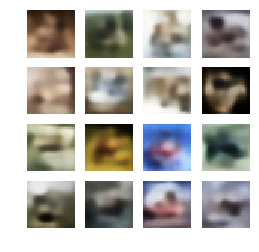

In [ ]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        gradient, loss = compute_gradient(model, train_x)
        apply_gradient(optimizer, gradient, model.trainable_variables)
    end_time = time.time()
    
    if epoch % 1 == 0: 
        loss = tfe.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))

        generate_and_save_images(model, epoch, random_vector_for_generation)

In [ ]:
#displaying
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(epochs)

with imageio.get_writer('cvae.gif', mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# this is a hack to display the gif inside the notebook
os.system('cp cvae.gif cvae.gif.png')
display.Image(filename="cvae.gif.png")